In [250]:
import math
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.amp import autocast, GradScaler
torch.set_float32_matmul_precision('medium')

In [251]:
image_dim = 128
device = 'cuda'
num_time_channels = 32
batch_size = 16
num_epochs = 100

In [252]:
dset = torchvision.datasets.Flowers102(root='data/flowers-102',
                                       download=True,
                                       transform=transforms.Compose(
                                           (transforms.Resize((image_dim, image_dim)),
                                            transforms.ToTensor(),
                                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)))
                                       )
                                       )
dldr = DataLoader(dset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
next(iter(dldr))[0].shape

torch.Size([64, 3, 64, 64])

In [253]:
def fourier_time_features(batch_n, shape, time_samples):

    # Vectorized computation
    i_vec = torch.linspace(0, num_time_channels - 1, num_time_channels)
    factor = torch.exp(math.log(10_000) * i_vec / num_time_channels).to(device)
    factor = factor.view(1, -1)
    
    # Compute all angles at once: [batch, num_time_channels]
    angles = torch.pi * time_samples.view(-1, 1) / factor
    
    # Create cos and sin features: [batch, num_time_channels]
    cos_features = torch.cos(angles)
    sin_features = torch.sin(angles)
    
    # Alternate cos and sin: even indices = cos, odd indices = sin
    time_features = torch.zeros((batch_n, num_time_channels, *shape), device=device)
    time_features[:, ::2, ...] = cos_features[:, ::2].view(batch_n, -1, 1, 1)
    time_features[:, 1::2, ...] = sin_features[:, 1::2].view(batch_n, -1, 1, 1)
    
    return time_features

fourier_time_features(batch_size, (image_dim, image_dim), torch.randn(batch_size, device=device)).shape

torch.Size([64, 32, 64, 64])

In [254]:
def time_coefficients(time_values):
    time_values = torch.clamp(time_values, 0, 1)
    a_t = 1-time_values
    b_t = time_values
    return a_t.view((-1, 1, 1, 1)), b_t.view((-1, 1, 1, 1))

In [255]:
class ResidualLinear(nn.Module):
    def __init__(self, dim):
        super(ResidualLinear, self).__init__()
        self.linear = nn.Sequential(nn.Linear(dim, dim),
                                    nn.LeakyReLU())

    def forward(self, x):
        shape = x.shape
        out = x.view((shape[0], -1))
        out = self.linear(out)
        out = out.view(shape)
        return x+out

class UNet(nn.Module):
    def __init__(self, depth, channels, image_dims):
        super(UNet, self).__init__()
        self.conv_down = nn.Sequential(nn.Conv2d(in_channels=channels, out_channels=channels*2, kernel_size=3, stride=2, padding=1),
                                       nn.BatchNorm2d(channels*2),
                                       nn.ReLU(),
                                       nn.AdaptiveMaxPool2d((image_dims // 2, image_dims // 2)), )

        self.conv_up = nn.Sequential(nn.ConvTranspose2d(in_channels=channels*4, out_channels=channels, kernel_size=3, stride=2, padding=1),
                                     nn.BatchNorm2d(channels),
                                     nn.ReLU(),
                                     nn.AdaptiveMaxPool2d((image_dims, image_dims)), )

        if depth>1:
            self.sub_net = UNet(depth - 1, channels*2, image_dims // 2)
        else:
            self.sub_net = ResidualLinear(channels*2 * (image_dims // 2)**2)

    def forward(self, x):
        x = self.conv_down(x)
        out = self.sub_net(x)
        x = torch.cat((x, out), dim=1)
        x = self.conv_up(x)
        return x

In [256]:
flow_net = nn.Sequential(UNet(6, 3+num_time_channels, image_dim), nn.Conv2d(3+num_time_channels, 3, 1)).to(device)
flow_net.compile()
flow_net

Sequential(
  (0): UNet(
    (conv_down): Sequential(
      (0): Conv2d(35, 70, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(70, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): AdaptiveMaxPool2d(output_size=(32, 32))
    )
    (conv_up): Sequential(
      (0): ConvTranspose2d(140, 35, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(35, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): AdaptiveMaxPool2d(output_size=(64, 64))
    )
    (sub_net): UNet(
      (conv_down): Sequential(
        (0): Conv2d(70, 140, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(140, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): AdaptiveMaxPool2d(output_size=(16, 16))
      )
      (conv_up): Sequential(
        (0): ConvTranspose2d(280, 70, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)

In [257]:
loss_fn = nn.SmoothL1Loss()
optim = torch.optim.Adam(flow_net.parameters(), fused=True, lr=1e-3)
scaler = GradScaler()

In [258]:
import matplotlib.pyplot as plt

def sample_pic():
    n_steps = 10
    x_t = torch.randn((1, 3, image_dim, image_dim)).to(device)
    flow_net.eval()
    with torch.no_grad():
        for i in range(n_steps):
            time_values = i/n_steps*torch.ones(1).to(device)
            fourier_features = fourier_time_features(1, (image_dim, image_dim), time_values)
            x_t_in = torch.cat([x_t, fourier_features], dim=1)
            velocity_values = flow_net(x_t_in)
            x_t += velocity_values/n_steps

    plt.imshow((x_t[0].permute(1, 2, 0).cpu().clamp(-1, 1) + 1) / 2)
    plt.show()
    flow_net.train()

Epoch 1/100
Epoch [1/100], Loss: 0.484, Velocity 0.454


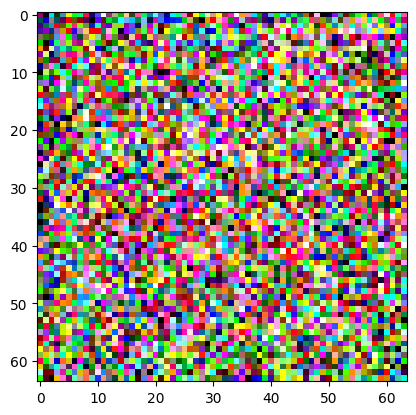

Epoch 2/100
Epoch [2/100], Loss: 0.690, Velocity 0.575


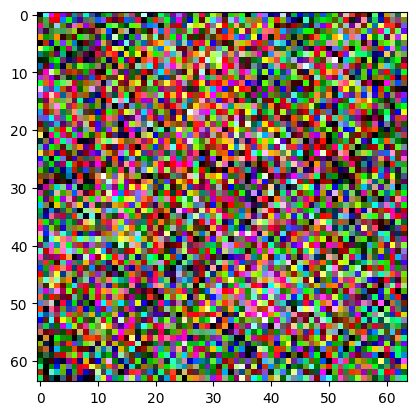

Epoch 3/100
Epoch [3/100], Loss: 0.618, Velocity 0.680


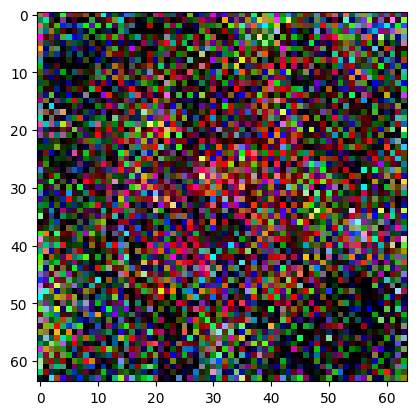

Epoch 4/100
Epoch [4/100], Loss: 0.564, Velocity 0.747


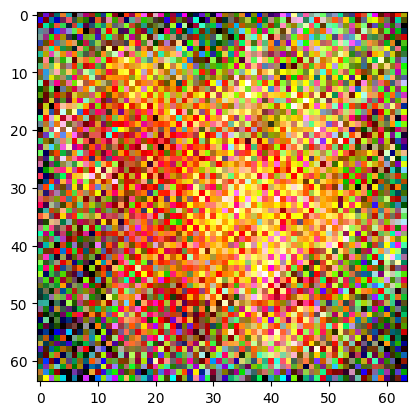

Epoch 5/100
Epoch [5/100], Loss: 0.537, Velocity 0.748


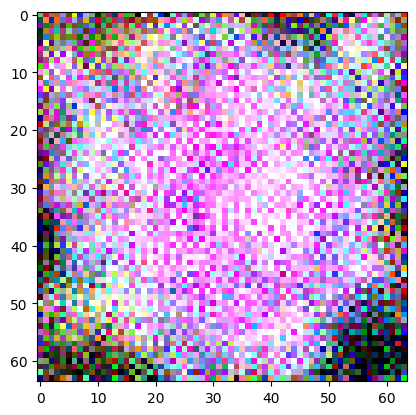

Epoch 6/100
Epoch [6/100], Loss: 0.513, Velocity 0.786


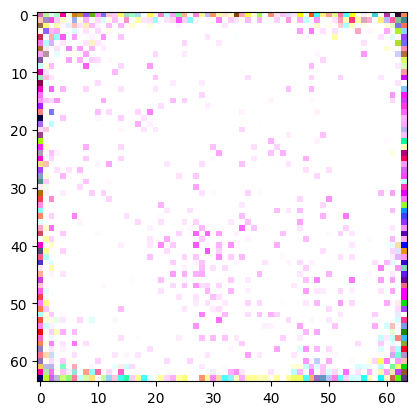

Epoch 7/100
Epoch [7/100], Loss: 0.504, Velocity 0.781


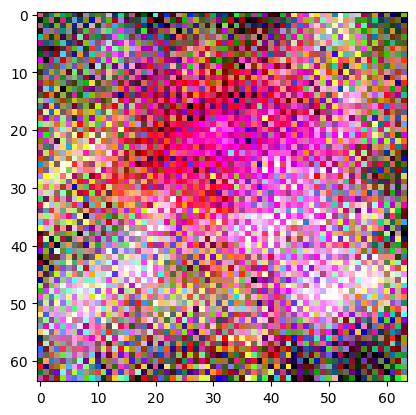

Epoch 8/100
Epoch [8/100], Loss: 0.494, Velocity 0.792


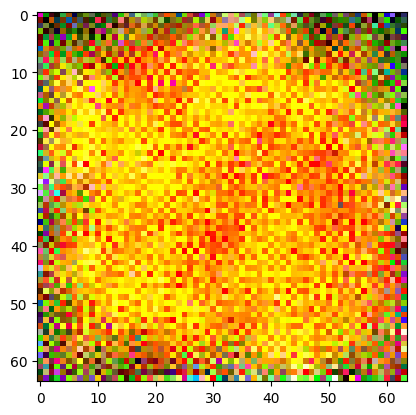

Epoch 9/100
Epoch [9/100], Loss: 0.485, Velocity 0.805


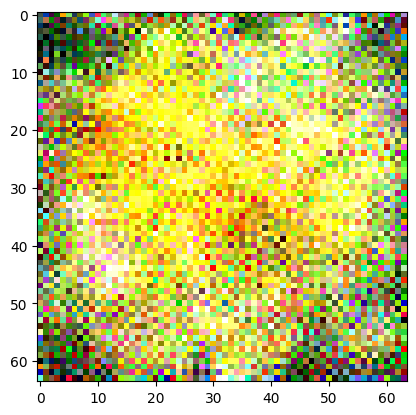

Epoch 10/100
Epoch [10/100], Loss: 0.478, Velocity 0.800


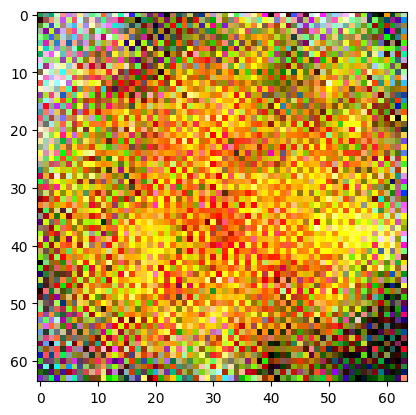

Epoch 11/100
Epoch [11/100], Loss: 0.472, Velocity 0.821


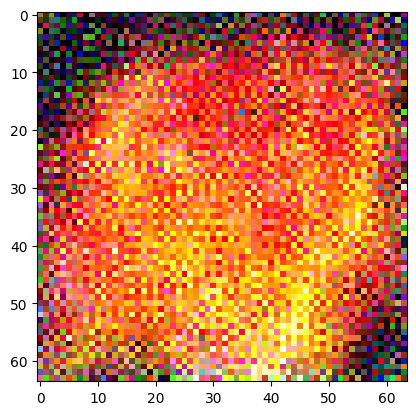

Epoch 12/100
Epoch [12/100], Loss: 0.469, Velocity 0.829


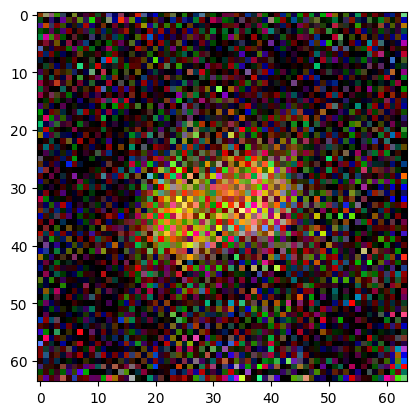

Epoch 13/100
Epoch [13/100], Loss: 0.459, Velocity 0.846


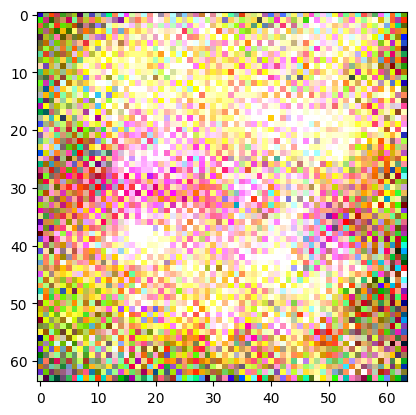

Epoch 14/100
Epoch [14/100], Loss: 0.455, Velocity 0.830


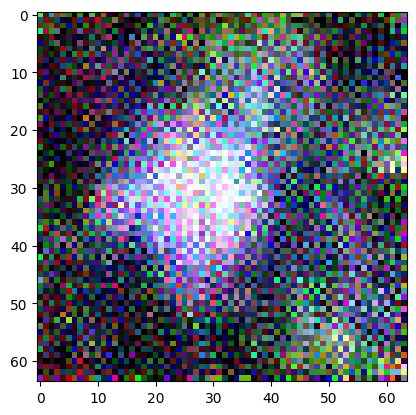

Epoch 15/100
Epoch [15/100], Loss: 0.455, Velocity 0.826


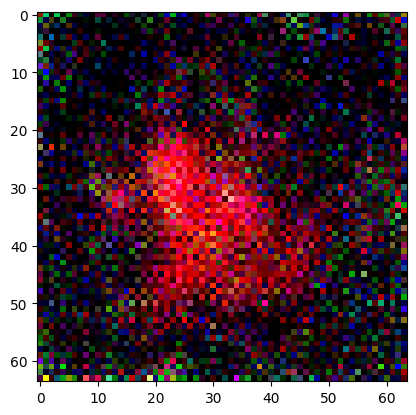

Epoch 16/100
Epoch [16/100], Loss: 0.448, Velocity 0.835


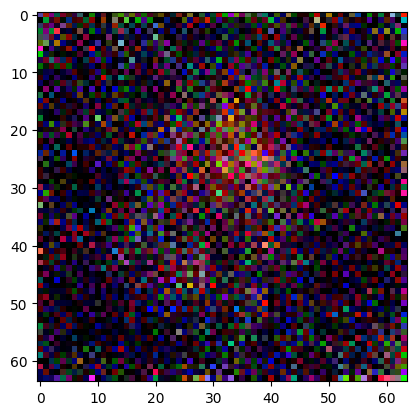

Epoch 17/100
Epoch [17/100], Loss: 0.440, Velocity 0.864


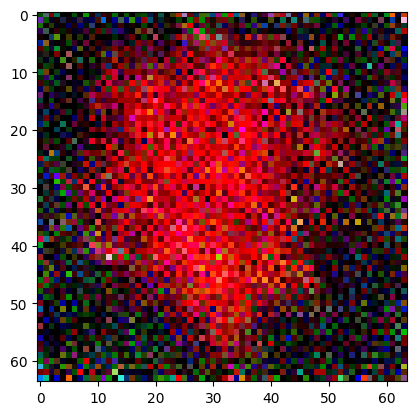

Epoch 18/100
Epoch [18/100], Loss: 0.440, Velocity 0.838


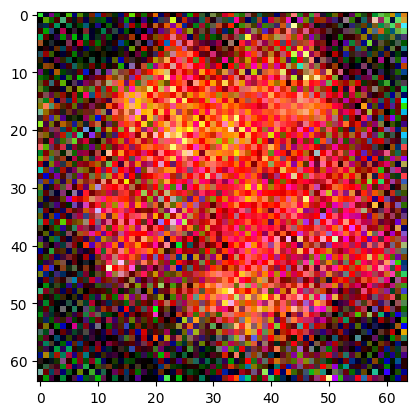

Epoch 19/100
Epoch [19/100], Loss: 0.445, Velocity 0.848


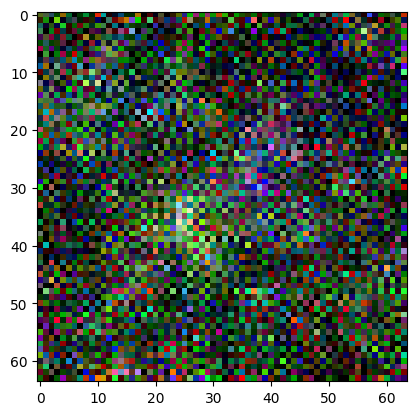

Epoch 20/100
Epoch [20/100], Loss: 0.439, Velocity 0.859


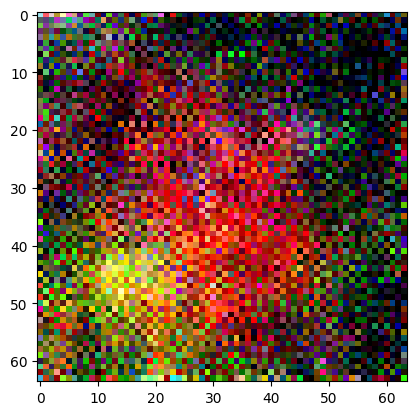

Epoch 21/100
Epoch [21/100], Loss: 0.428, Velocity 0.864


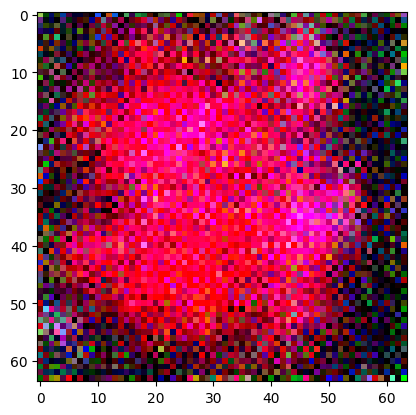

Epoch 22/100
Epoch [22/100], Loss: 0.433, Velocity 0.874


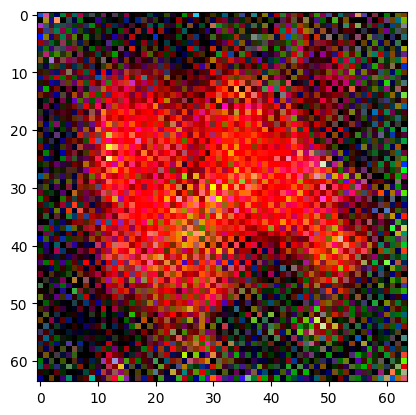

Epoch 23/100
Epoch [23/100], Loss: 0.425, Velocity 0.838


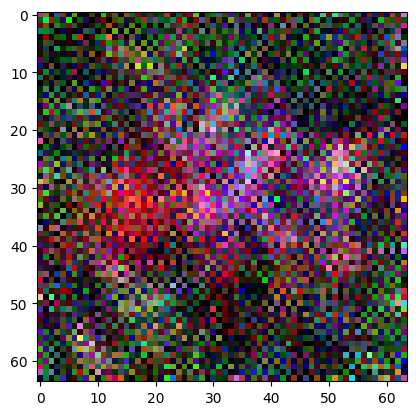

Epoch 24/100
Epoch [24/100], Loss: 0.430, Velocity 0.848


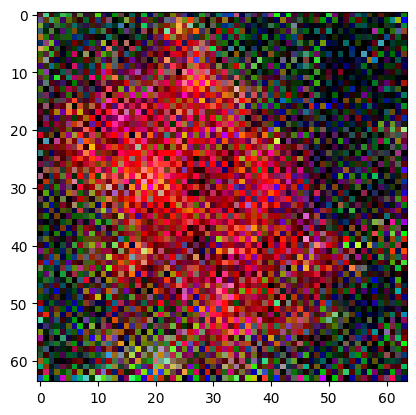

Epoch 25/100
Epoch [25/100], Loss: 0.426, Velocity 0.843


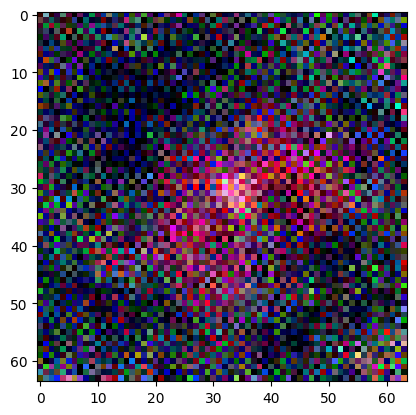

Epoch 26/100
Epoch [26/100], Loss: 0.417, Velocity 0.876


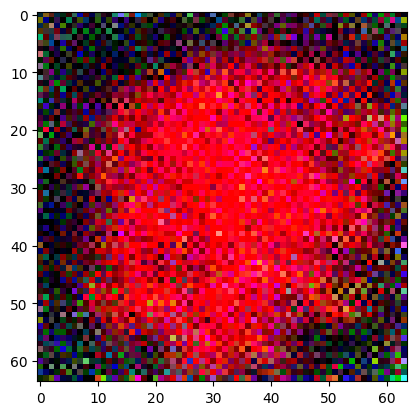

Epoch 27/100
Epoch [27/100], Loss: 0.421, Velocity 0.853


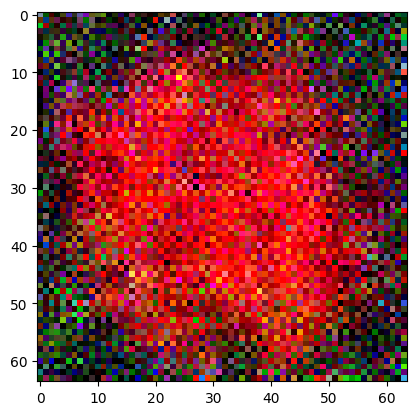

Epoch 28/100
Epoch [28/100], Loss: 0.416, Velocity 0.886


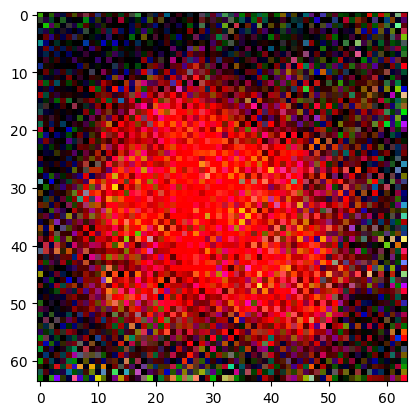

Epoch 29/100
Epoch [29/100], Loss: 0.413, Velocity 0.856


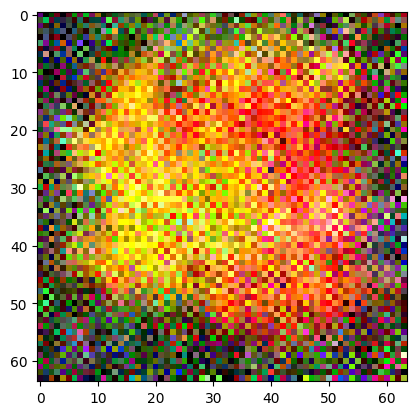

Epoch 30/100
Epoch [30/100], Loss: 0.411, Velocity 0.876


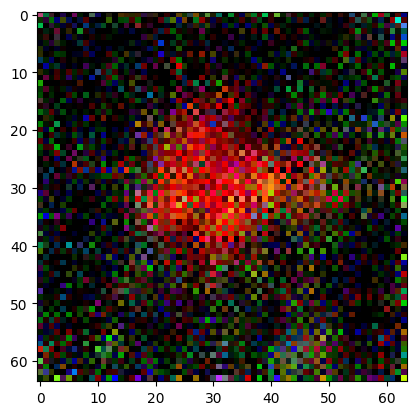

Epoch 31/100
Epoch [31/100], Loss: 0.409, Velocity 0.896


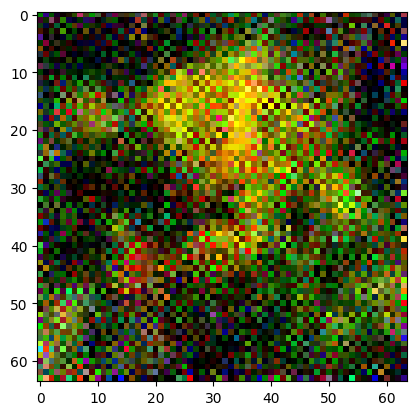

Epoch 32/100
Epoch [32/100], Loss: 0.410, Velocity 0.882


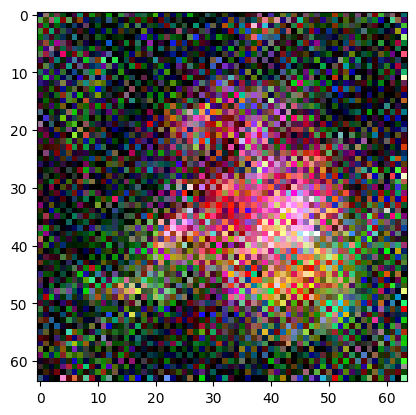

Epoch 33/100
Epoch [33/100], Loss: 0.409, Velocity 0.866


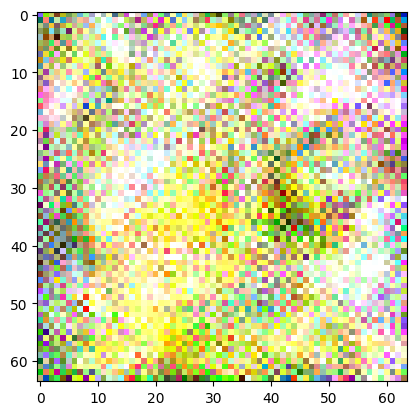

Epoch 34/100
Epoch [34/100], Loss: 0.405, Velocity 0.891


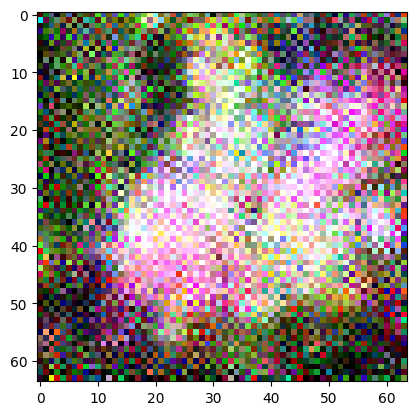

Epoch 35/100
Epoch [35/100], Loss: 0.397, Velocity 0.874


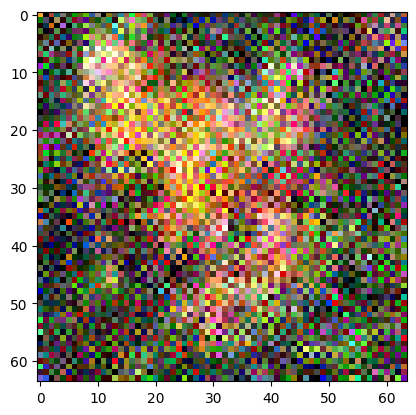

Epoch 36/100
Epoch [36/100], Loss: 0.402, Velocity 0.884


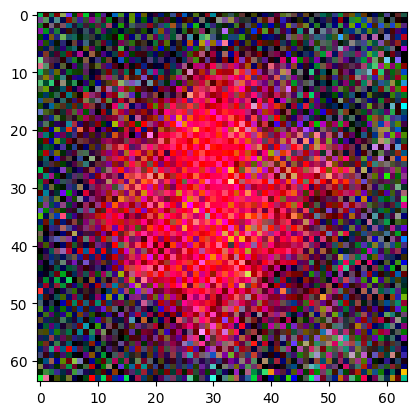

Epoch 37/100
Epoch [37/100], Loss: 0.403, Velocity 0.911


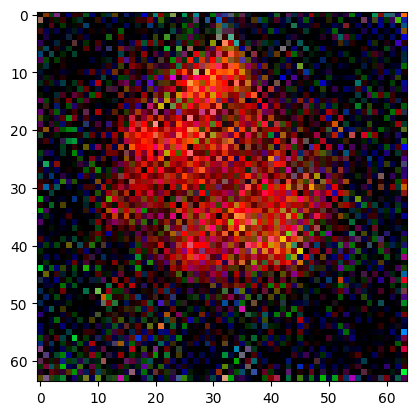

Epoch 38/100
Epoch [38/100], Loss: 0.399, Velocity 0.868


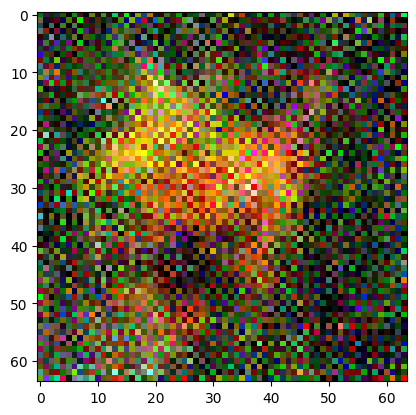

Epoch 39/100
Epoch [39/100], Loss: 0.396, Velocity 0.900


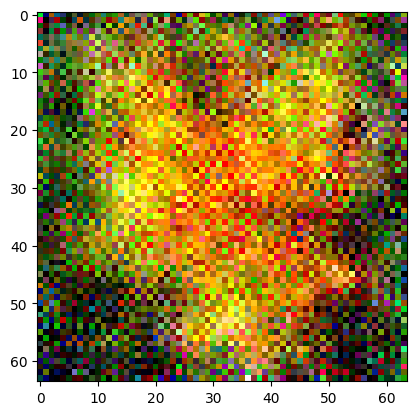

Epoch 40/100
Epoch [40/100], Loss: 0.393, Velocity 0.894


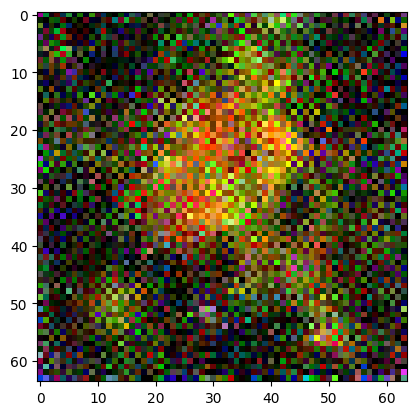

Epoch 41/100
Epoch [41/100], Loss: 0.388, Velocity 0.868


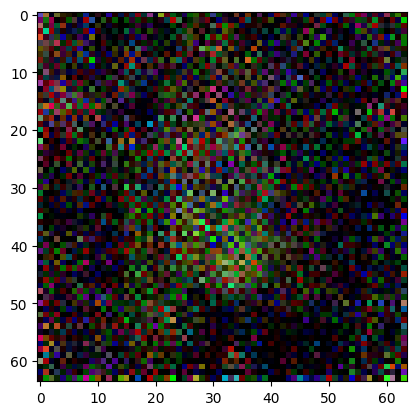

Epoch 42/100
Epoch [42/100], Loss: 0.391, Velocity 0.878


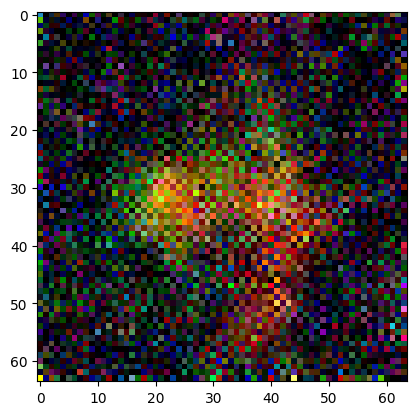

Epoch 43/100
Epoch [43/100], Loss: 0.391, Velocity 0.881


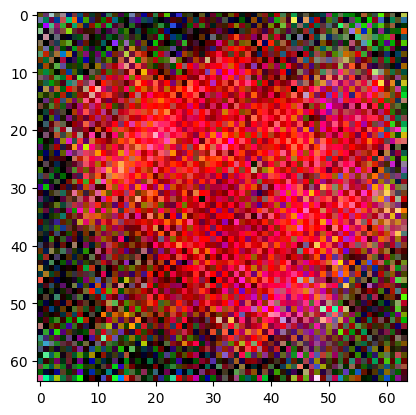

Epoch 44/100
Epoch [44/100], Loss: 0.388, Velocity 0.905


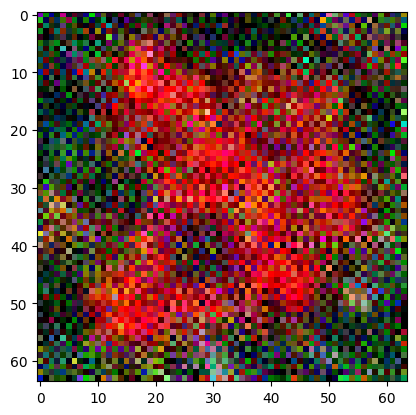

Epoch 45/100
Epoch [45/100], Loss: 0.385, Velocity 0.875


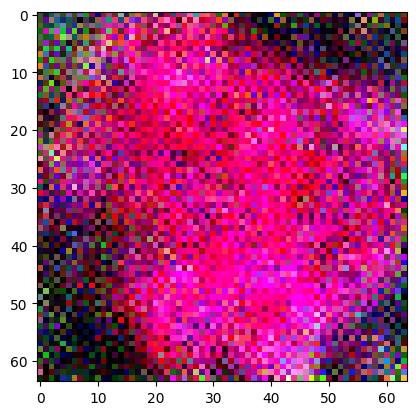

Epoch 46/100
Epoch [46/100], Loss: 0.383, Velocity 0.926


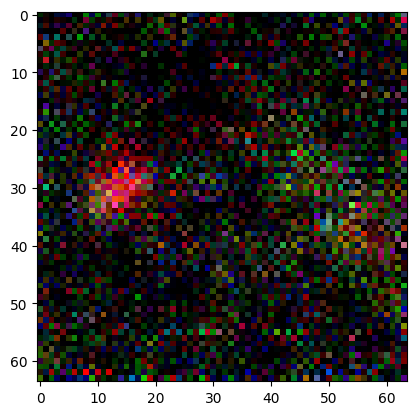

Epoch 47/100
Epoch [47/100], Loss: 0.379, Velocity 0.908


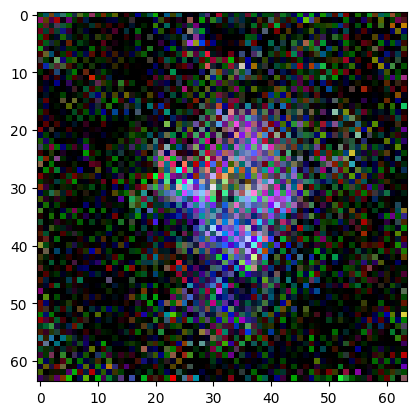

Epoch 48/100
Epoch [48/100], Loss: 0.386, Velocity 0.907


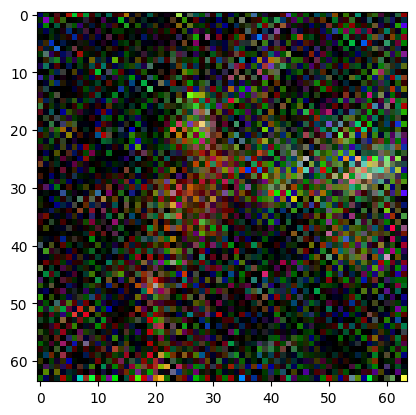

Epoch 49/100
Epoch [49/100], Loss: 0.383, Velocity 0.882


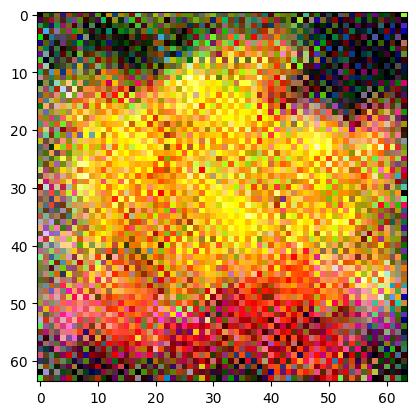

Epoch 50/100
Epoch [50/100], Loss: 0.388, Velocity 0.889


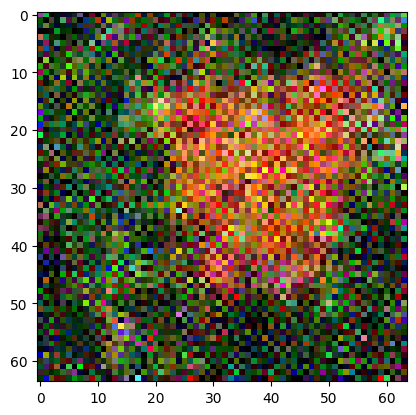

Epoch 51/100
Epoch [51/100], Loss: 0.382, Velocity 0.895


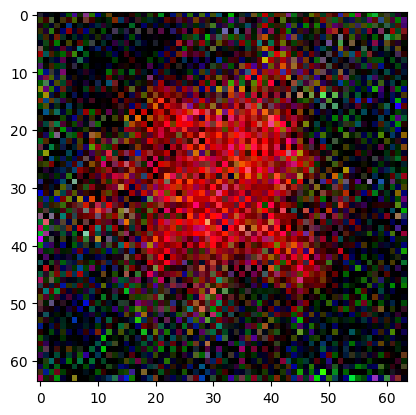

Epoch 52/100
Epoch [52/100], Loss: 0.379, Velocity 0.903


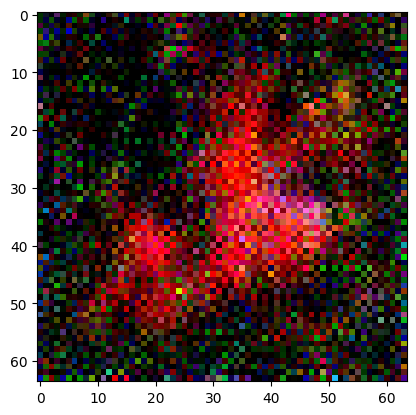

Epoch 53/100
Epoch [53/100], Loss: 0.375, Velocity 0.911


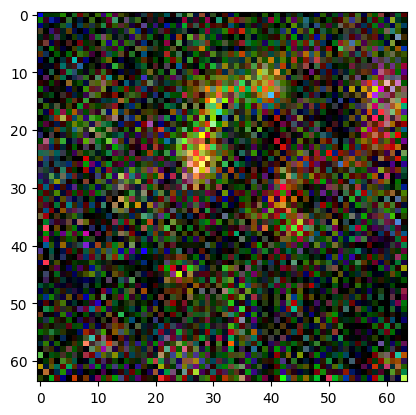

Epoch 54/100
Epoch [54/100], Loss: 0.375, Velocity 0.911


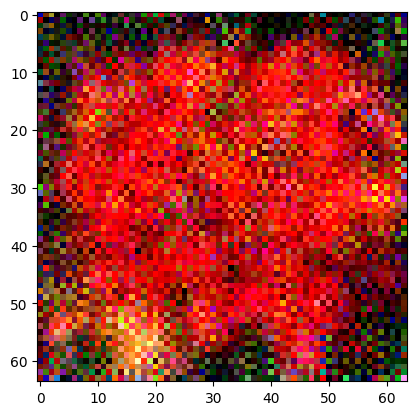

Epoch 55/100
Epoch [55/100], Loss: 0.373, Velocity 0.917


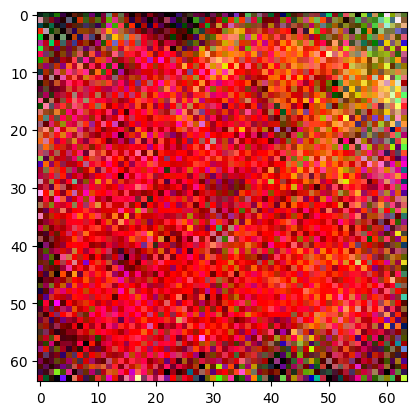

Epoch 56/100
Epoch [56/100], Loss: 0.375, Velocity 0.896


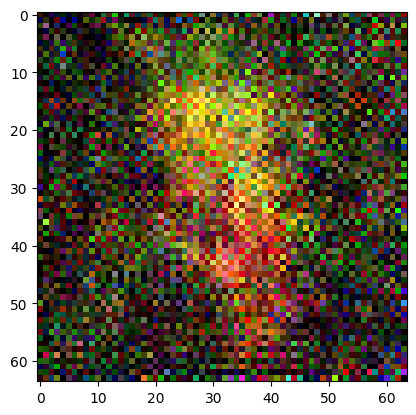

Epoch 57/100
Epoch [57/100], Loss: 0.377, Velocity 0.926


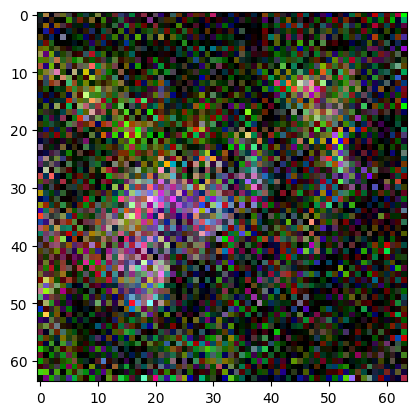

Epoch 58/100
Epoch [58/100], Loss: 0.372, Velocity 0.919


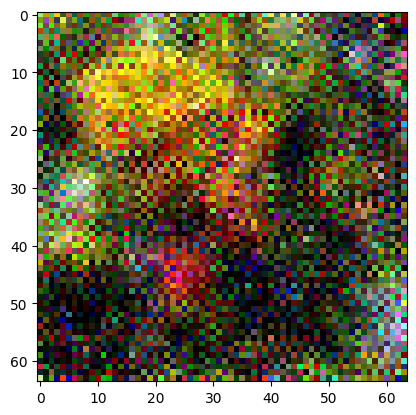

Epoch 59/100
Epoch [59/100], Loss: 0.368, Velocity 0.879


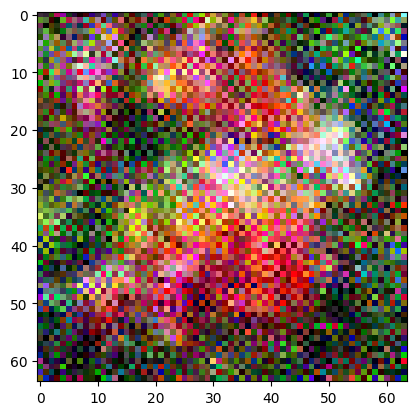

Epoch 60/100
Epoch [60/100], Loss: 0.369, Velocity 0.917


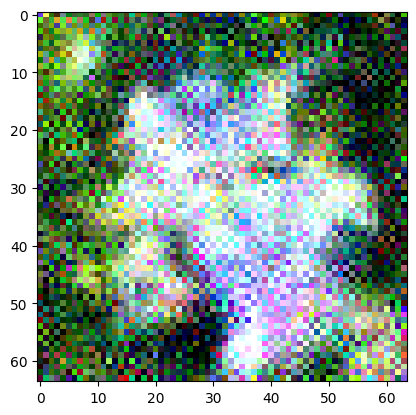

Epoch 61/100
Epoch [61/100], Loss: 0.368, Velocity 0.912


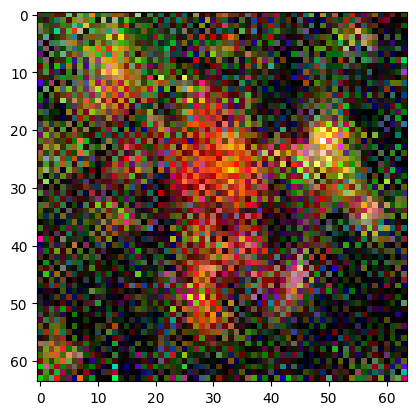

Epoch 62/100
Epoch [62/100], Loss: 0.372, Velocity 0.891


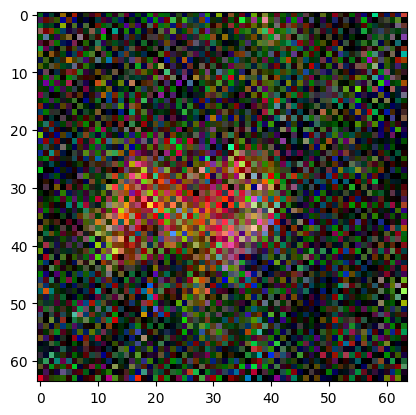

Epoch 63/100
Epoch [63/100], Loss: 0.369, Velocity 0.916


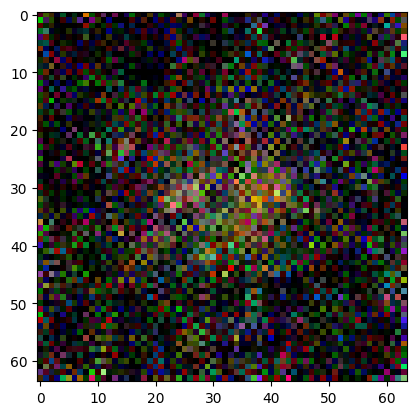

Epoch 64/100
Epoch [64/100], Loss: 0.359, Velocity 0.915


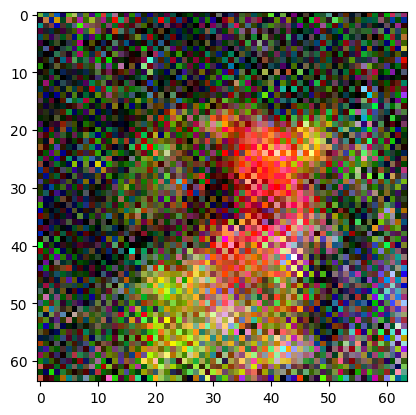

Epoch 65/100
Epoch [65/100], Loss: 0.364, Velocity 0.911


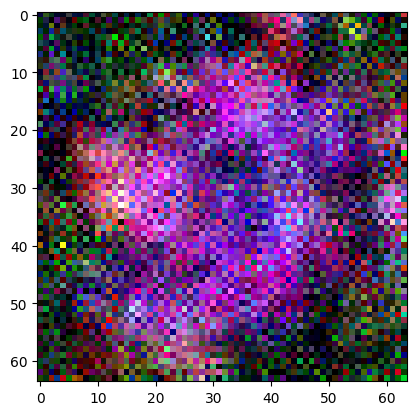

Epoch 66/100
Epoch [66/100], Loss: 0.366, Velocity 0.912


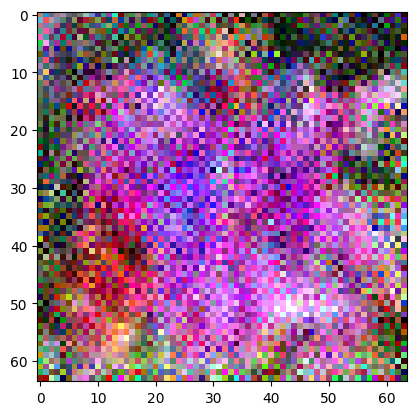

Epoch 67/100
Epoch [67/100], Loss: 0.366, Velocity 0.932


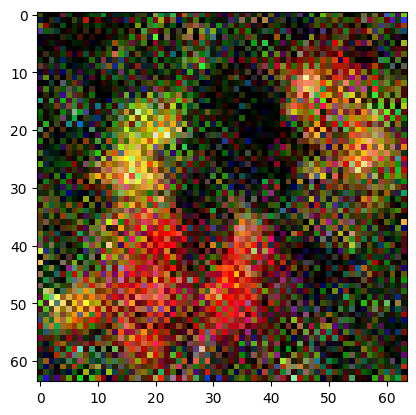

Epoch 68/100
Epoch [68/100], Loss: 0.362, Velocity 0.927


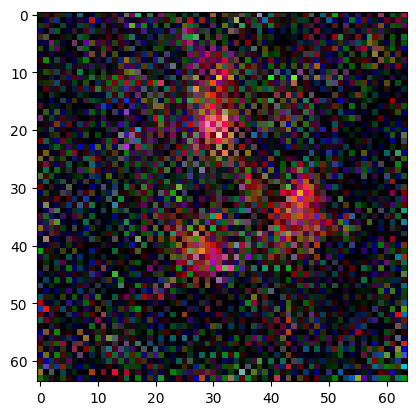

Epoch 69/100
Epoch [69/100], Loss: 0.364, Velocity 0.885


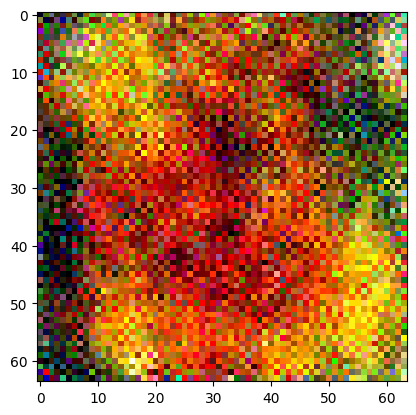

Epoch 70/100
Epoch [70/100], Loss: 0.369, Velocity 0.915


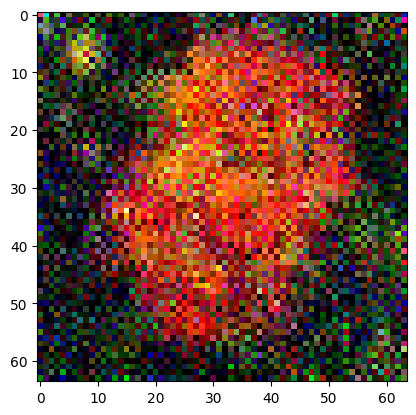

Epoch 71/100
Epoch [71/100], Loss: 0.364, Velocity 0.925


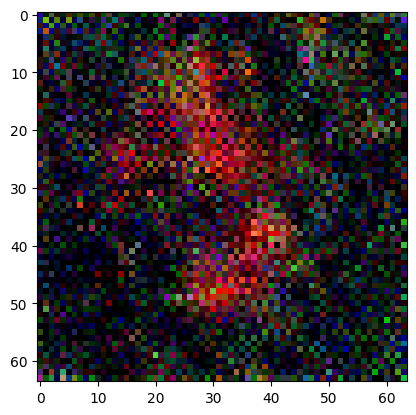

Epoch 72/100
Epoch [72/100], Loss: 0.358, Velocity 0.918


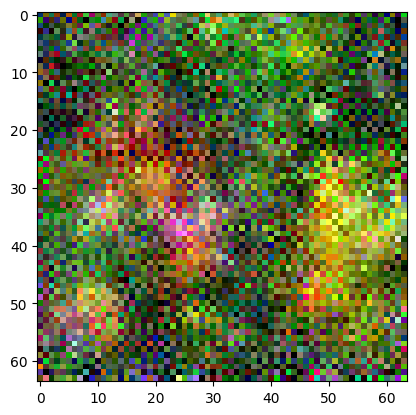

Epoch 73/100
Epoch [73/100], Loss: 0.362, Velocity 0.922


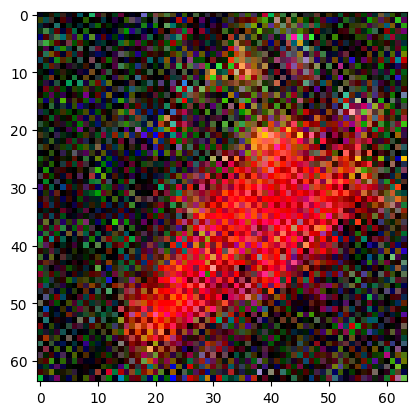

Epoch 74/100
Epoch [74/100], Loss: 0.350, Velocity 0.944


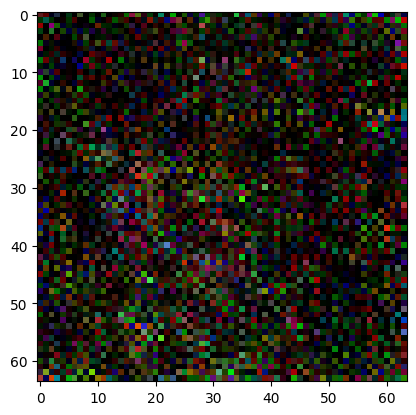

Epoch 75/100
Epoch [75/100], Loss: 0.357, Velocity 0.894


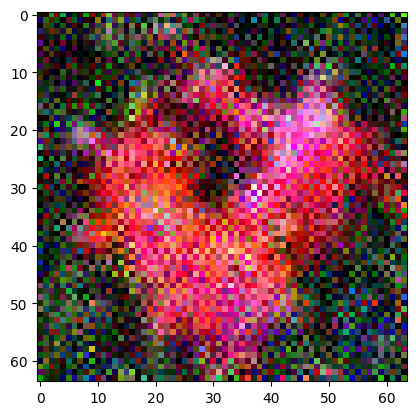

Epoch 76/100
Epoch [76/100], Loss: 0.357, Velocity 0.916


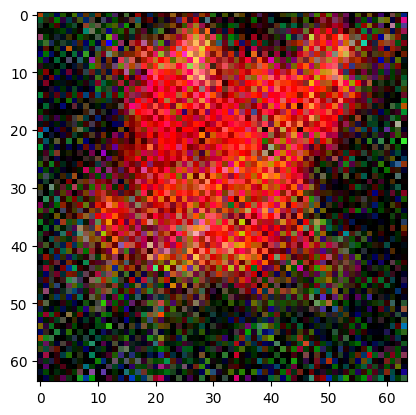

Epoch 77/100
Epoch [77/100], Loss: 0.352, Velocity 0.937


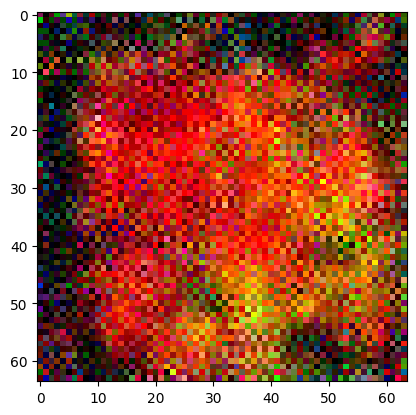

Epoch 78/100
Epoch [78/100], Loss: 0.349, Velocity 0.940


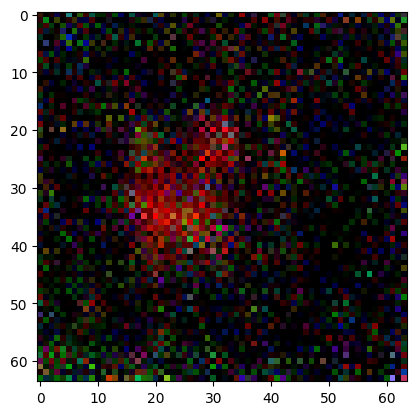

Epoch 79/100
Epoch [79/100], Loss: 0.352, Velocity 0.909


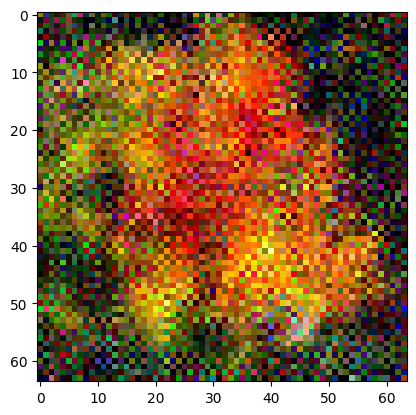

Epoch 80/100
Epoch [80/100], Loss: 0.358, Velocity 0.897


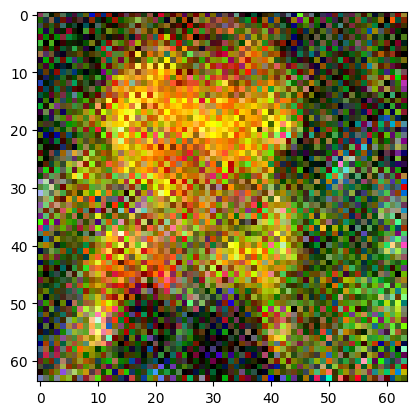

Epoch 81/100
Epoch [81/100], Loss: 0.349, Velocity 0.939


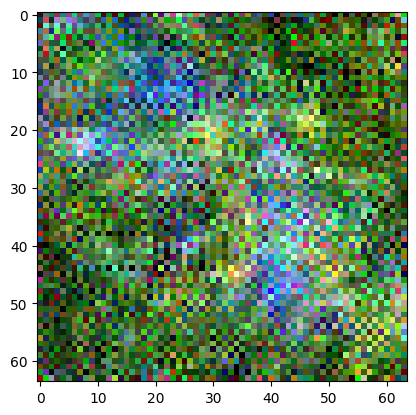

Epoch 82/100
Epoch [82/100], Loss: 0.350, Velocity 0.897


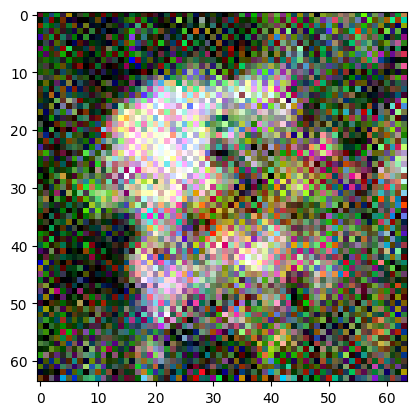

Epoch 83/100
Epoch [83/100], Loss: 0.349, Velocity 0.935


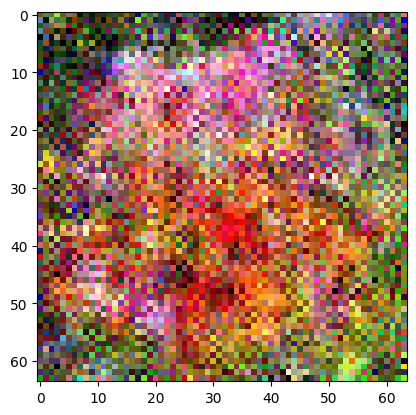

Epoch 84/100
Epoch [84/100], Loss: 0.344, Velocity 0.919


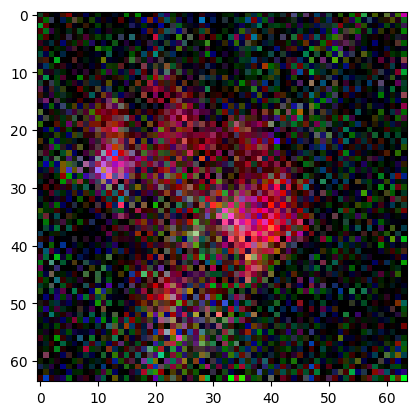

Epoch 85/100
Epoch [85/100], Loss: 0.347, Velocity 0.912


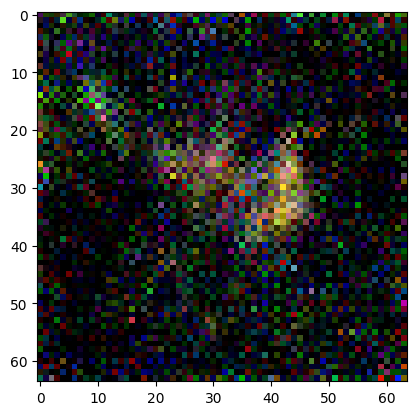

Epoch 86/100
Epoch [86/100], Loss: 0.357, Velocity 0.910


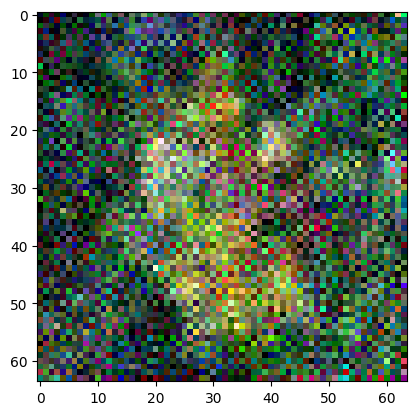

Epoch 87/100
Epoch [87/100], Loss: 0.345, Velocity 0.945


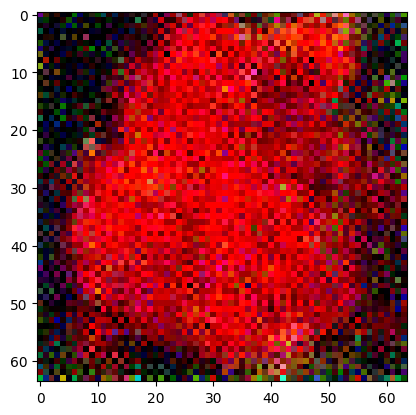

Epoch 88/100
Epoch [88/100], Loss: 0.346, Velocity 0.936


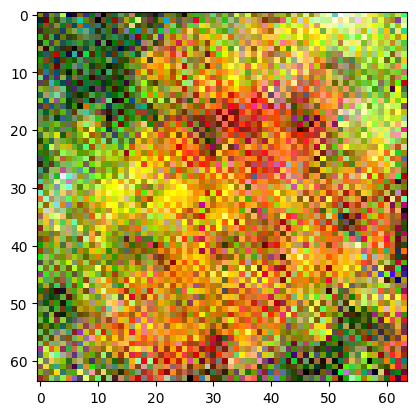

Epoch 89/100
Epoch [89/100], Loss: 0.346, Velocity 0.932


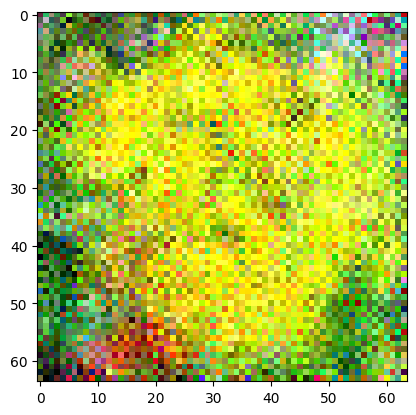

Epoch 90/100
Epoch [90/100], Loss: 0.348, Velocity 0.896


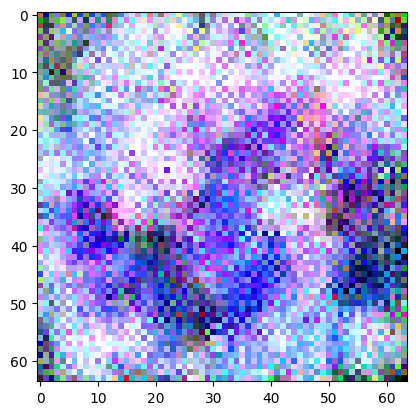

Epoch 91/100
Epoch [91/100], Loss: 0.347, Velocity 0.898


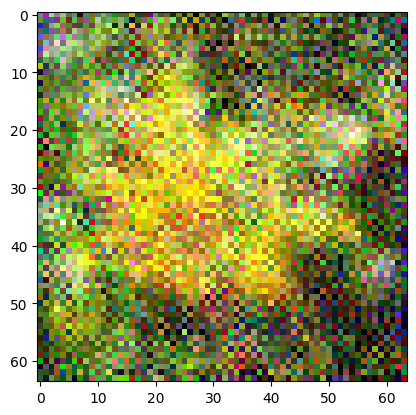

Epoch 92/100
Epoch [92/100], Loss: 0.348, Velocity 0.914


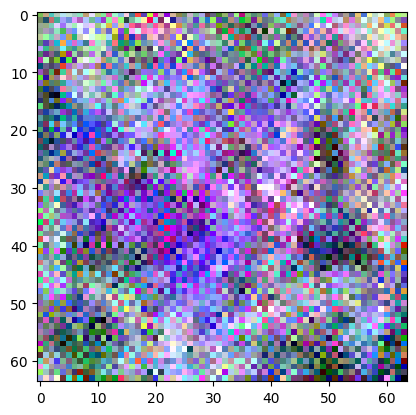

Epoch 93/100
Epoch [93/100], Loss: 0.343, Velocity 0.940


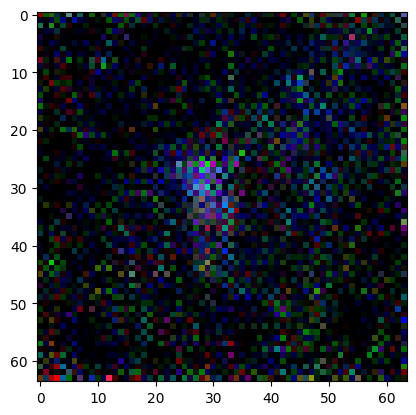

Epoch 94/100
Epoch [94/100], Loss: 0.344, Velocity 0.894


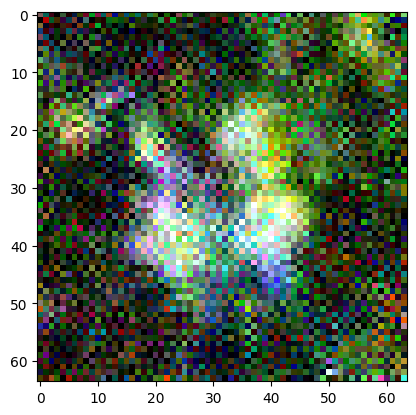

Epoch 95/100
Epoch [95/100], Loss: 0.340, Velocity 0.931


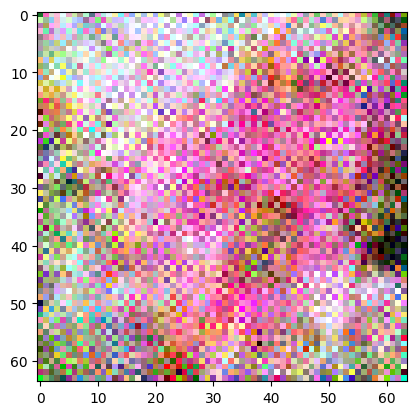

Epoch 96/100
Epoch [96/100], Loss: 0.338, Velocity 0.947


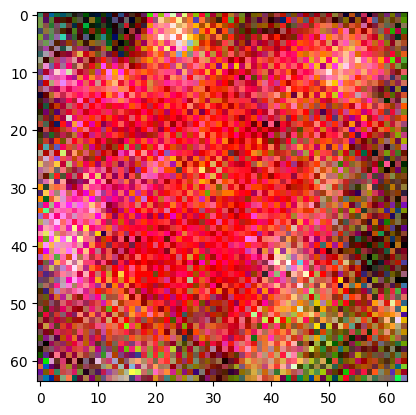

Epoch 97/100
Epoch [97/100], Loss: 0.337, Velocity 0.936


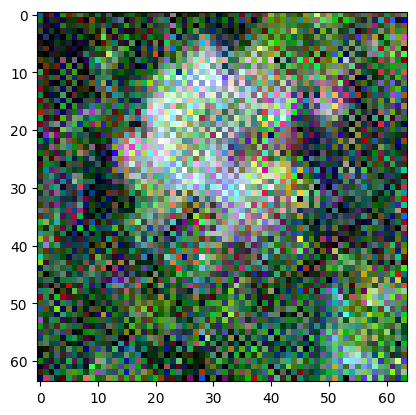

Epoch 98/100
Epoch [98/100], Loss: 0.338, Velocity 0.926


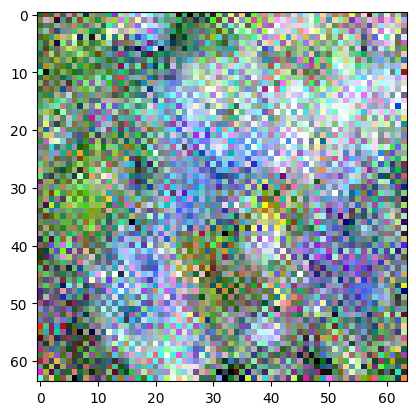

Epoch 99/100
Epoch [99/100], Loss: 0.335, Velocity 0.946


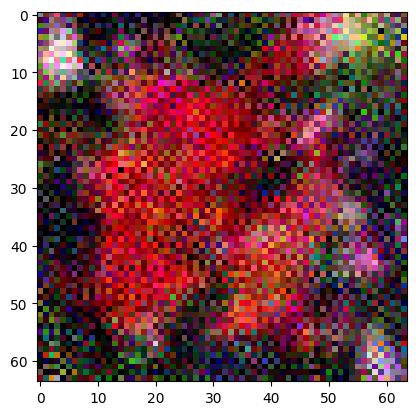

Epoch 100/100
Epoch [100/100], Loss: 0.335, Velocity 0.934


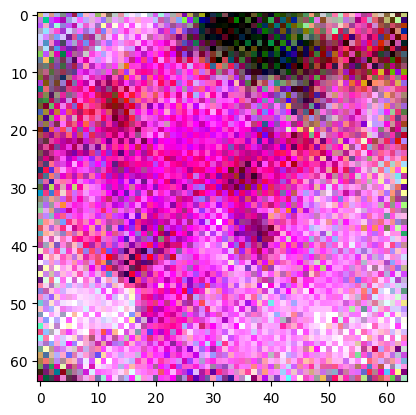

In [259]:
running_loss = 0.0
for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    for i, batch in enumerate(dldr):
        x_1, _ = batch
        x_0 = torch.randn((x_1.shape[0], 3, image_dim, image_dim), device=device)
        x_1 = x_1.to(device)

        times = torch.rand(x_0.shape[0]).to(device)
        a, b = time_coefficients(times)

        x_t = a * x_0 + b * x_1
        fourier = fourier_time_features(x_t.shape[0], (image_dim, image_dim), times)

        x_in = torch.cat((x_t, fourier), dim=1)

        with autocast(device_type=device):
            velocity = flow_net(x_in)
            loss = loss_fn(velocity, x_1 - x_0)
        
        running_loss += loss.item()
        optim.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optim)
        scaler.update()
        
        if i%10 == 9:
            print('Epoch [{}/{}], Loss: {:.3f}, Velocity {:.3f}'.format(epoch+1, num_epochs,
                                                                        running_loss/10, (velocity**2).mean()**0.5))
            sample_pic()
            running_loss = 0.0
            #plt.imshow((x_1[0].permute(1, 2, 0).cpu().clamp(-1, 1) + 1) / 2)
            #plt.show()

In [261]:
torch.save(flow_net.state_dict(), 'flow_net.pth')